<a href="https://colab.research.google.com/github/ChamaniS/ANN-exercises/blob/master/HAR_using_CNN__LSTM_Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import numpy as np
import keras
import _pickle as cPickle

import tensorflow
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import time
from sklearn import metrics
import csv

Using TensorFlow backend.


In [0]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [0]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded


In [0]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_' + group + '.txt', 'total_acc_y_' + group + '.txt', 'total_acc_z_' + group + '.txt']
    # body acceleration
    filenames += ['body_acc_x_' + group + '.txt', 'body_acc_y_' + group + '.txt', 'body_acc_z_' + group + '.txt']
    # body gyroscope
    filenames += ['body_gyro_x_' + group + '.txt', 'body_gyro_y_' + group + '.txt', 'body_gyro_z_' + group + '.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_' + group + '.txt')
    return X, y

In [0]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/gdrive/My Drive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/gdrive/My Drive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


In [0]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
 
    # define model
    verbose, epochs, batch_size = 1, 100,64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
     # fit network
   # ts1 = time.time()
   # print ("time1",ts1)
    history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(testX, testy))
    
   # ts2 = time.time()
   # print ("time2",ts2)
   # print("time2-time1",(ts2-ts1))
       # test model
    #ts3 = time.time()
    #print ("time3",ts3)
    test_model(model, testX, verbose, batch_size, n_outputs)
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    #ts4 = time.time()
    #print ("time4",ts4)
    #print("time4-time3",(ts4-ts3))
    return accuracy,history


In [0]:
# fit and evaluate a model
def test_model(model, testX, verbose, batch_size, n_outputs):
 
    prediction_list = model.predict(testX, batch_size=batch_size, steps=None, verbose=verbose)
    predictions_transformed = np.eye(n_outputs, dtype=int)[np.argmax(prediction_list, axis=1)]

    np.savetxt('predictions.txt', prediction_list)
    np.savetxt('predictions_trans.txt', (np.argmax(predictions_transformed, axis=1)))

In [0]:
def plot_accuracy(history):
      acc = history.history['acc']
      val_acc = history.history['val_acc']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      epochs = range(1, len(acc) + 1)
      plt.plot(epochs, acc, 'bo', label='Training acc')
      plt.plot(epochs, val_acc, 'orange', label='Validation acc')
      plt.title('Training and validation accuracy')
      plt.legend()
      plt.figure()

In [0]:
def plot_loss(history):
      acc = history.history['acc']
      val_acc = history.history['val_acc']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      epochs = range(1, len(acc) + 1)
      plt.plot(epochs, loss, 'bo', label='Training loss')
      plt.plot(epochs, val_loss, 'orange', label='Validation loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.figure()

In [0]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [0]:
def plot_predictions():
    x = list(range(1, 101))
    actual = read_csv("/content/gdrive/My Drive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", nrows=100, header=None, delim_whitespace=True)
    predicted = read_csv("predictions_trans.txt", nrows=100, header=None, delim_whitespace=True)
    predicted = ([x+1 for x in np.array(predicted)])
    plt.plot(x, actual)
    plt.plot(x, predicted, color='r')
    plt.show()

    with open('/content/gdrive/My Drive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt', newline='') as csvfile:
       actualok = list(csv.reader(csvfile))

    with open('predictions_trans.txt', newline='') as csvfile:
       predictedok = list(csv.reader(csvfile))


    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(actualok, predictedok)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
    # Plot Results: 
    width = 8
    height = 8
  
    plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")


    print(normalised_confusion_matrix)

    LABELS = [
        "WALKING", 
        "WALKING_UPSTAIRS", 
        "WALKING_DOWNSTAIRS", 
        "SITTING", 
        "STANDING", 
        "LAYING"
    ]
    plt.colorbar()
    tick_marks = np.arange(6)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [0]:
def run_experiment(repeats=5):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    #repeat experiment
    scores=list()
    for r in range(repeats):
        score,history = evaluate_model(trainX, trainy, testX, testy)
        score=score*100.0
        print("Accuracy : ", score)
        plot_predictions()
        plot_accuracy(history)
        plot_loss(history)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 896)         0         
______________________________

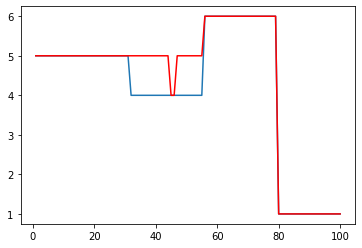

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [475   0   1   0  20   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 446   0  24   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   0   2   0 414   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  24   0   0   0 387   0  80   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0  56   0 473   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 537   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [16.118088    0.          0.03393281  0.          0.6786562   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

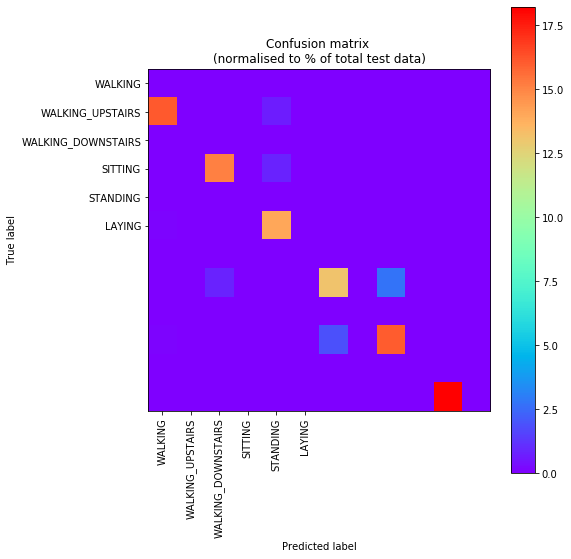

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 896)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)              

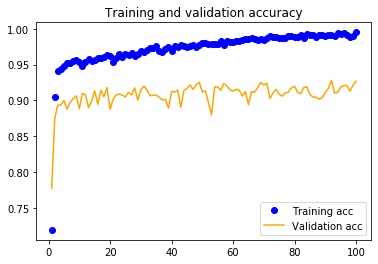

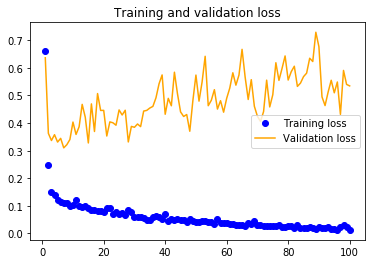

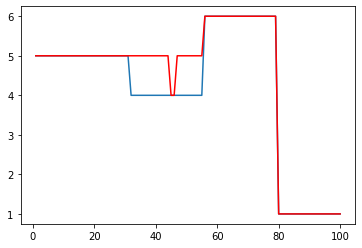

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [467   0   0   0  29   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 445   0  25   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 420   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   5   0   1   0 407   0  74   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  59   0 473   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  26   0   0   0   0   0   0   0 511   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [15.846623    0.          0.          0.          0.9840515   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

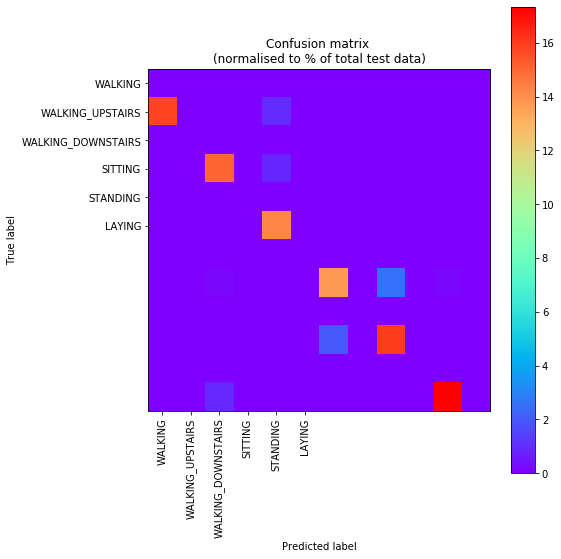

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 896)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)              

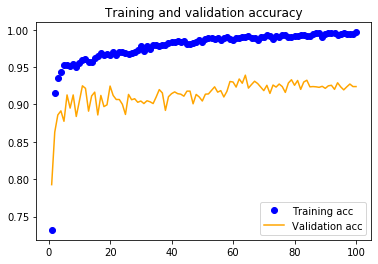

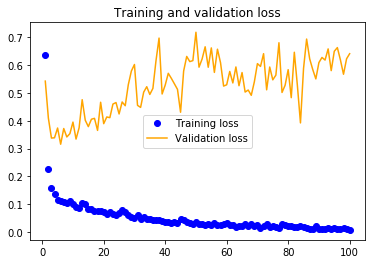

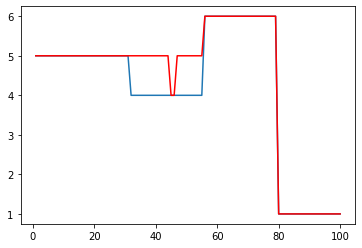

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [471   0   4   0  21   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 447   0  23   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   0   0   0 416   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   5   0   1   0 373   0 112   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0  50   0 481   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0  26   0 510   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [15.982355    0.          0.13573125  0.          0.7125891   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

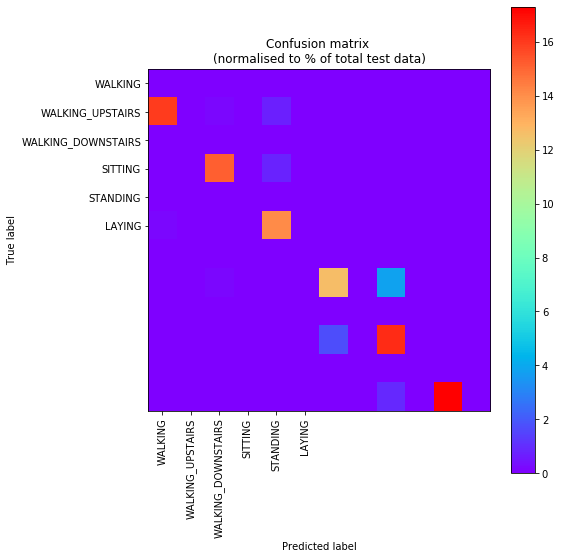

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 896)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)              

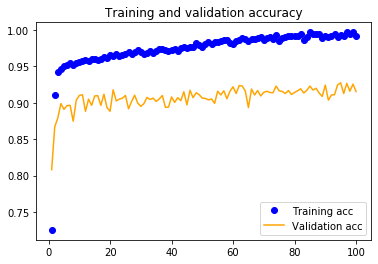

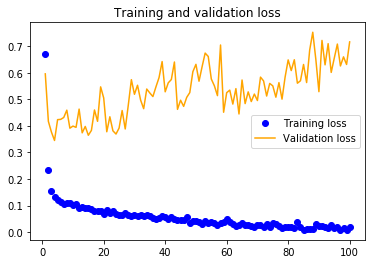

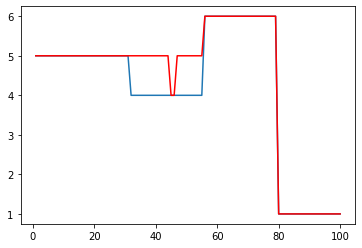

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [489   0   0   0   7   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [ 10   0 438   0  22   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [ 14   0   1   0 405   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  20   0   0   0 408   0  58   0   5   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0  98   0 433   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0   0   0 535   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [16.593145    0.          0.          0.          0.2375297   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

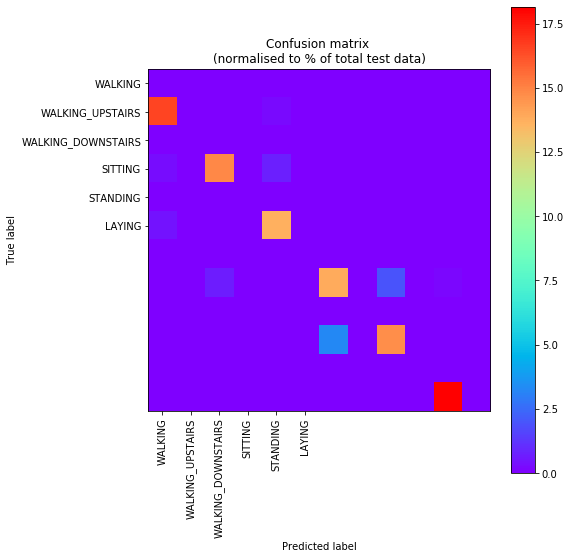

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 896)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)              

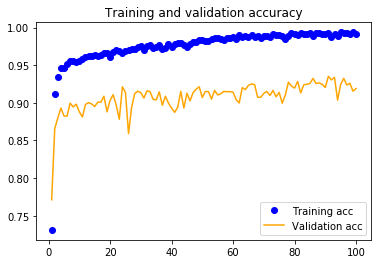

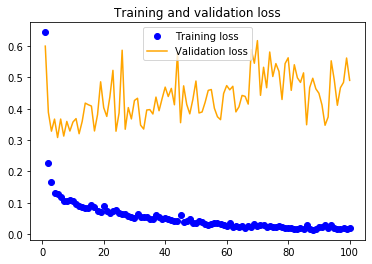

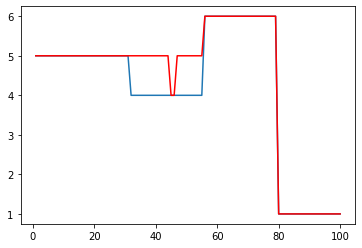

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [476   0   0   0  20   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [ 12   0 435   0  24   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   0   1   0 415   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0 389   0  92   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0  56   0 475   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  27   0   0   0   0   0   0   0 510   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [16.152018    0.          0.          0.          0.6786562   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

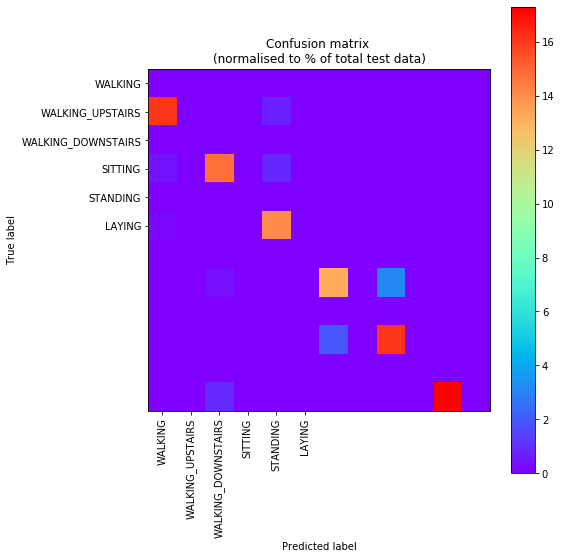

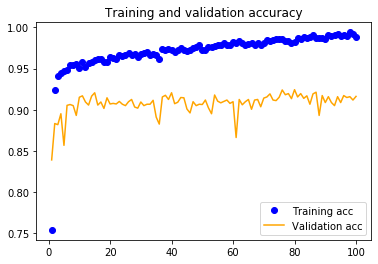

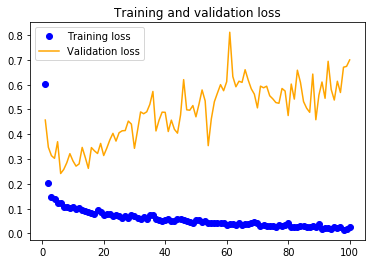

<Figure size 432x288 with 0 Axes>

In [14]:
# run the experiment
run_experiment()

In [16]:
import pandas as pd
df = pd.read_csv('predictions_trans.txt', sep=" ", header=None, names=["Prediction"])
temp_dict={0:'Walking',
           1:'Walking-upstairs',
           2:'Walking-downstairs',
           3:'Sitting',
           4:'Standing',
           5:'Laying'}

df['Prediction']=df.Prediction.map(temp_dict)
df

,Prediction
0,Standing
1,Standing
2,Standing
3,Standing
4,Standing
...,...
2942,Walking-upstairs
2943,Walking-upstairs
2944,Walking-upstairs
2945,Walking-upstairs


In [0]:
df.to_csv(r'activity_predictions.txt', header=None, index=None, sep='\t', mode='a')